# Interpreting Data from the Spotify API 
## jdkazime@buffalo.edu

### Import Statements

In [2]:
# Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials as SCC

# Data structures
import numpy as np

# Graphing
import networkx as nx
from matplotlib import pyplot as plt

### Signing up for the API

In order to use this data, one needs to first sign-up for the Spotify API with the following links:

https://developer.spotify.com/documentation/web-api/

https://developer.spotify.com/dashboard/login

Then, one should store their token and secret below.  Note that they have to be stored as a string, in order to be understood by the library. Of course, these should be kept private:

In [4]:
token = ''
secret = ''

If having difficult in finding the secret, it may be hidden and have to be revealed.

### Looking at the Data

Now, one can look at the data.  First, Spotify must be queried.  If successful, then a dictionary (from an XML) will be returned.

In [5]:
# First, create a session.
session = spotipy.Spotify(auth_manager = SCC(token, secret))

In [8]:
# Then, define an artist and query their data.
artist = 'Billie Eilish'
results = session.search(q = artist, limit = 50)

# Here, q is the query and the limit is the total number of results.
# 50 is the default, since that's the maximum amount Spotify allows.

In [24]:
# The first key:  it stores all the tracks.
print(results.keys())

# The actual set of keys:
print(results['tracks'].keys())

# The only one important here is item; the rest are just inherent
# to querying the data, but aren't data themselves.

# These are the results for any given track.  For the purpose of this,
# it is important to look at artists.  The other keys have their
# significance, but this notebook relys on 'artists'.
print(results['tracks']['items'][0].keys())

# This gives information regarding the lead artist on the track.
print(results['tracks']['items'][0]['artists'][0].keys())

# Finally, the name of the artist:
print(results['tracks']['items'][0]['artists'][0]['name'])

dict_keys(['tracks'])
dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])
dict_keys(['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'id', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri'])
dict_keys(['external_urls', 'href', 'id', 'name', 'type', 'uri'])
Billie Eilish


### Artist Connectivity

In order to create adjacency matrix from the data, one must first create an edge list.  In this case, edges are defined as unweighted, undirected, and without self edges.  This ultimately means a symmetrical binary array.  The binary is defined by whether or not two artists have collaborated and henceforth, each edge represents such.

In [57]:
# First, define a starting point:
artist = 'Kanye West'
results = np.array(session.search(q = artist, limit = 50)['tracks']['items'])

# Now, iterate over the array to make sure the first point is
# the same artist that was input.  Sometimes, a track named
# similarly to the artist is more popular than the artist. 
# Since this is sorted by popularity, those results would show first
# and lead to an incorrect analysis.
isartist = np.array([np.array([entry['artists'][i]['name'].lower() == artist.lower() for i in range(len(entry['artists']))]).any() for entry in results])

# Then, check to see if a track is a collaboration or not.  This is
# true if there are more than one artists on a track.
iscollab = np.array([len(entry['artists']) for entry in results]) > 1

# Finally, filter by 1.) the correct artist and 2.) only collabs.
correct_results = results[iscollab & isartist]

Then, this leads to a simple solution:  iterate through each artist and store them in some kind of data structure.  Here, a dictionary will be used to keep track of whether or not an artist has collaborated.  Once an artist is exhausted, iterate through the next artist on a list.  

In [60]:
# First, declare the number of desired artists in a dictionary:
number_artists = 50

# Then, create an empty dictionary:
artists = {}

# Finally, iterate over each artist:
starting_artist = 'Kanye West'
queue = [starting_artist]; dequeued = []

# Note that both conditions are imposed here because it's possible
# to hit a dead end for nicher artists or large enough N,
# without meeting the initial goal.
while (len(artists) != number_artists) & (queue != []):
    head = queue[0]; queue.pop(0); dequeued.append(head)
    if head not in artists:
        artists[head] = []
    
    results = np.array(session.search(q = head, limit = 50)['tracks']['items'])
    
    isartist = np.array([np.array([entry['artists'][idx]['name'].lower() == head.lower() for idx in range(len(entry['artists']))]).any() for entry in results])
    iscollab = np.array([len(entry['artists']) for entry in results]) > 1

    correct_results = results[iscollab & isartist]
    for entry in correct_results:
        for person in entry['artists']:
            name = person['name']
            if name.lower() != head.lower():
                artists[head].append(name)
            if (name not in queue) and (name not in dequeued):
                queue.append(name)

In [77]:
adjusted_artists['Kanye West']

{'artists': array(['2 Chainz', 'Big Sean', 'Bon Iver', 'Chance the Rapper',
        "Chicago Children's Choir", 'Chris Martin', 'Desiigner', 'Dwele',
        'Estelle', 'FKA twigs', 'Gucci Mane', 'JAY-Z', 'Jamie Foxx',
        'Jeezy', 'Kid Cudi', 'Lil Pump', 'Lil Uzi Vert', 'Lil Wayne',
        'Lupe Fiasco', 'Nicki Minaj', 'PARTYNEXTDOOR', 'Paul McCartney',
        'Pusha T', 'Quavo', 'Raekwon', 'Rick Ross', 'Rihanna', 'Skrillex',
        'Syleena Johnson', 'T-Pain', 'Travis Scott', 'Ty Dolla $ign',
        'Tyler, The Creator', 'YNW Melly', 'Yo Gotti'], dtype='<U24'),
 'counts': array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
        2, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1])}

In [70]:
# Then, convert into unweighted and weighted dictionaries:
adjusted_artists = {}
for name in artists:
    names, counts = np.unique(artists[name], return_counts = True)
    adjusted_artists[name] = {'artists': names, 'counts': counts}

### Creating the Adjacency Matrix

Now, the adjacency matrix can be created with the pseudo-edgelist.  It is important to note that artists not in the keys of the dictionary must be filtered out, since they're not an individual node.

In [87]:
# First, get all of the node names.  This will be used in
# NetworkX, as well.
artist_names = list(adjusted_artists.keys())

# Then, define an empty adjacency matrix:
N = len(artist_names); A = np.zeros((N, N))

for idx, val in enumerate(adjusted_artists.values()):
    weights = np.array([name in val['artists'] for name in artist_names]).astype(int)
    A[idx, :] = weights

# Remove self edges.
A -= np.diag(np.diag(A))

Now, spying the matrix:

In [157]:
# Just for saving purposes.
folder = 'figures/'

# Most OS don't recognize spaces in filenames.
reduced_artist = ''
parts = starting_artist.split(' ')
for idx, part in enumerate(parts):
    reduced_artist += part.lower() + '_'

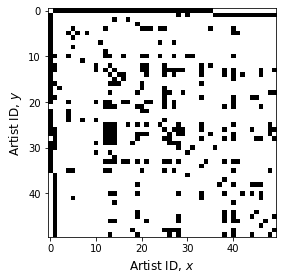

In [160]:
fig, ax = plt.subplots(1, 1, figsize = (4,4))

ax.spy(A)

ax.set_ylabel('Artist ID, $y$', fontsize = 12)
ax.set_xlabel('Artist ID, $x$', fontsize = 12); ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()
fig.savefig(folder + 'asymmetrical_A_' + reduced_artist + str(N) + '.pdf')
fig.savefig(folder + 'asymmetrical_A_' + reduced_artist + str(N) + '.png')

The adjacency matrix here is asymmetrical, so the following fix is simple:

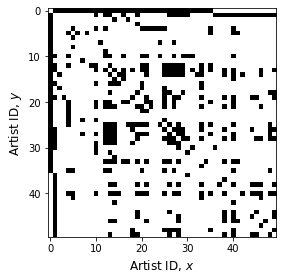

In [161]:
# This works because it is fair to assume that if an artist collabed with another, but
# it doesn't show up in the matrix, then it's just because 50 entries is not enough.
# The lack of entries is a limiting factor in this API.  Collaboration is not defined here
# by simply who "owns" the song, either.

a = np.triu(A) + np.tril(A).T
adjusted_A = a + a.T

fig, ax = plt.subplots(1, 1, figsize = (4,4))

ax.spy(adjusted_A)

ax.set_ylabel('Artist ID, $y$', fontsize = 12)
ax.set_xlabel('Artist ID, $x$', fontsize = 12); ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()
fig.savefig(folder + 'symmetrical_A_' + reduced_artist + str(N) + '.pdf')
fig.savefig(folder + 'symmetrical_A_' + reduced_artist + str(N) + '.png')

### NetworkX Visualization

The adjacency matrix can now be easily visualized by NetworkX:

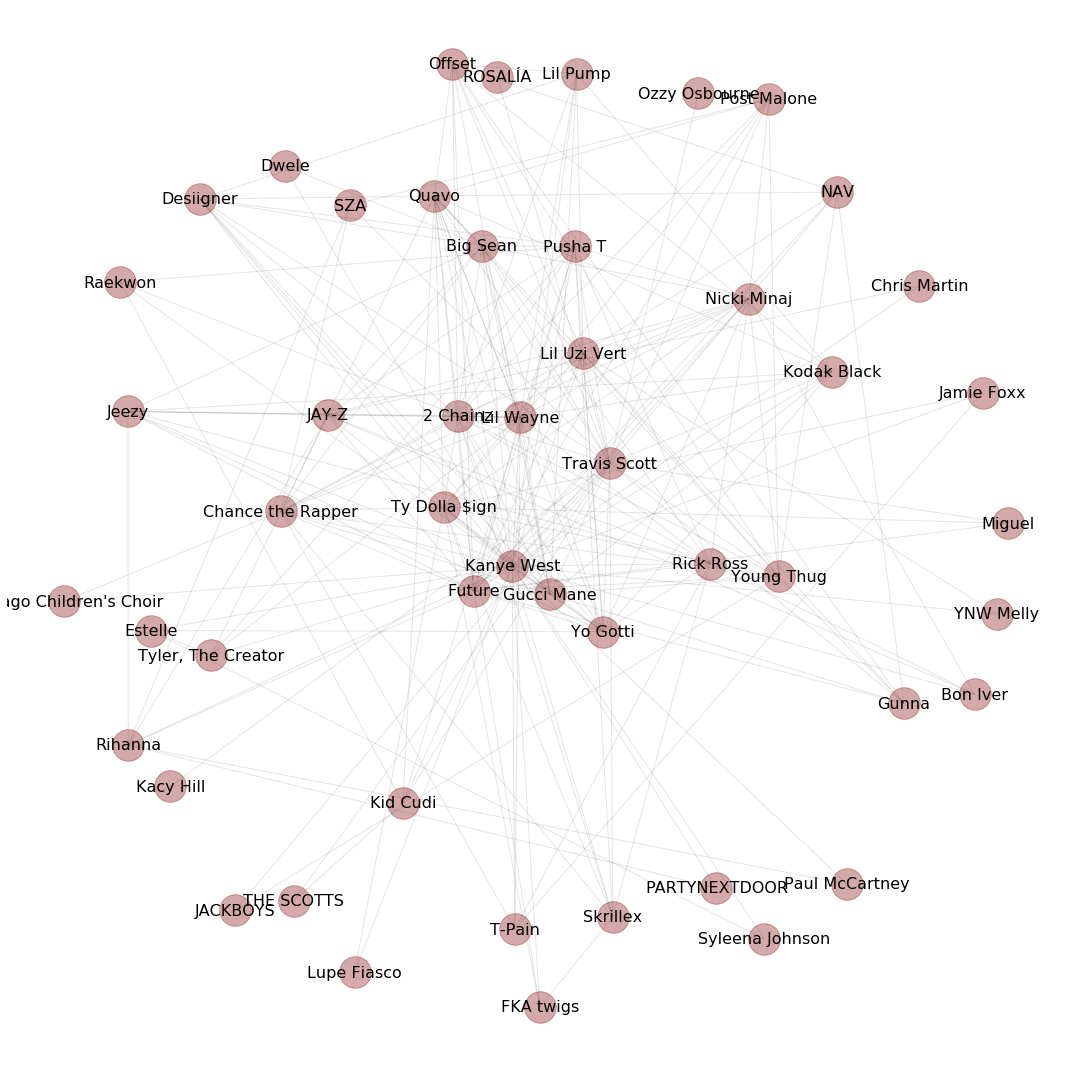

In [191]:
# First, declare a Graph object:
G = nx.from_numpy_array(adjusted_A)

# Then, generate labels for the nodes:
labels = {i: artist_names[i] for i in range(N)}

# And the position of said nodes and edges.  k can be adjusted, but the default
# is k = 1/N.
pos = nx.spring_layout(G, k = 2)

# Create an empty figure, so the figure size can be adjusted.
# It should be adjusted if the entire network does not fit in the window.
fig = plt.figure(1, figsize = (15, 15))

# Draw the nodes.  The last three parameters can be adjusted at will.
nx.draw_networkx_nodes(G, 
                       pos, 
                       node_color = 'maroon', 
                       alpha = 1/3, 
                       node_size = 1000)

# Draw the edges.  Alpha can be adjusted.
nx.draw_networkx_edges(G, 
                       pos, 
                       alpha = 1/10)

# Finally, draw the labels.  Font size can be adjusted.
nx.draw_networkx_labels(G, 
                        pos, 
                        labels, 
                        font_size=16);

plt.axis('off')
fig.tight_layout()

fig.savefig(folder + 'networkx' + reduced_artist + str(N) + '.pdf')
fig.savefig(folder + 'networkx' + reduced_artist + str(N) + '.png')

### Understanding Connectivity

In a quick and final exploration, one can see the most connected parts of the network:

In [174]:
# The degree of each node determines the connectivity of said node:
D = np.sum(adjusted_A, axis = 1); ranked_D = D.argsort()[::-1]

# Then the names associated with these degrees can be sorted.
ranked_by_degree = np.array(artist_names)[ranked_D]

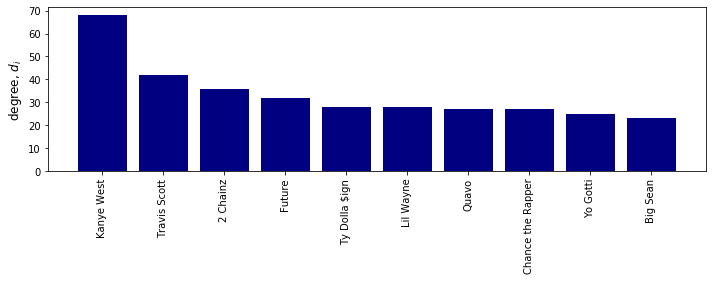

In [189]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4))

# Choose the top 10 artists.
x = 10 

ax.bar(ranked_by_degree[:x], D[ranked_D][:x], color = 'navy')

plt.xticks(rotation = '90')
ax.set_ylabel('degree, $d_i$', fontsize = 12);

fig.tight_layout()
fig.savefig(folder + 'connectivity' + reduced_artist + str(N) + '.pdf')
fig.savefig(folder + 'connectivity' + reduced_artist + str(N) + '.png')

This shows ultimately which artists have the greatest influences on the network.  Of course, the input artist in most cases should be removed, as it is expected that they'll have greater influence.  However, this could lead into explorations on what happens if these artists are taken off of Spotify.

### Conclusion

The biggest flaw with this model is that Spotify can only by queried up to 50 entries per artist.  This is a problem because the features of said artist aren't fully covered and not even my adaption can truly fix this problem.  And, not all 50 songs are from the targeted artist.  So, at most, this can only be considered an approximation of an artist's network.

Of course, there's also the issue of artists not being on Spotify, but this is not necessarily their fault and cannot be immediately addressed.  False labeling or discluding artists in features, however, can be.

This is also time dependent in that the top 50 songs are going to shuffle depending on their popularity; if an artist were to release a new song or album, it could bump songs downward and change the network structure.

At least with the last point, this could lend to further exploration, in seeing how a network for one artist changes over a larger span of time given the same infrastructure and input variables.

Along similar lines, one could look at the weighted matrix.  That code is there; it just has to be adjusted with the 'counts' in the adjusted dictionary, accordingly.  The weights are subject to the same flaws as the unweighted, of course.

As always, there are always more things to do with this.  I'm just spitballing what comes to mind.  

<b>Jeremy can be found at: jdkazime@buffalo.edu</b>